In [73]:
import graspy
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from numpy.random import multivariate_normal

from graspy.embed import select_dimension, AdjacencySpectralEmbed
from graspy.utils import remove_loops, symmetrize, binarize
from graspy.inference.latent_distribution_test import _median_sign_flips, _fit_plug_in_variance_estimator
from graspy.inference import LatentDistributionTest

from hyppo.ksample import KSample
from hyppo._utils import gaussian

from joblib import Parallel, delayed

import sys
sys.path.append("./")
from seedless_procrustes import *

%matplotlib inline

print(graspy.__version__)

sns.set_context("talk")

0.3.0


In [2]:
def convert_classes(to_change):
    simple_classes = ['PN', 'APL', 'MBIN', 'MBON', 'KC']
    
    out = []
    for string in to_change:
        for simple_class in simple_classes:
            if simple_class in string:
                out.append(simple_class)
                
    return out

In [3]:
G = nx.read_graphml("./data/G.graphml")

G_l = G.subgraph([node for node, data in G.nodes(data=True) if data['Hemisphere'] == 'left'])
A_l = remove_loops(nx.to_numpy_array(G_l))
nodes_l = convert_classes([data['Class'] for node, data in G_l.nodes(data=True)])

G_r = G.subgraph([node for node, data in G.nodes(data=True) if data['Hemisphere'] in ['right', 'center']])
A_r = remove_loops(nx.to_numpy_array(G_r))
nodes_r = convert_classes([data['Class'] for node, data in G_r.nodes(data=True)])

hemispheres = ['Left'] * 163 + ['Right'] * 158

print(len(nodes_l), len(nodes_r))

163 158


<AxesSubplot:title={'center':'Right'}>

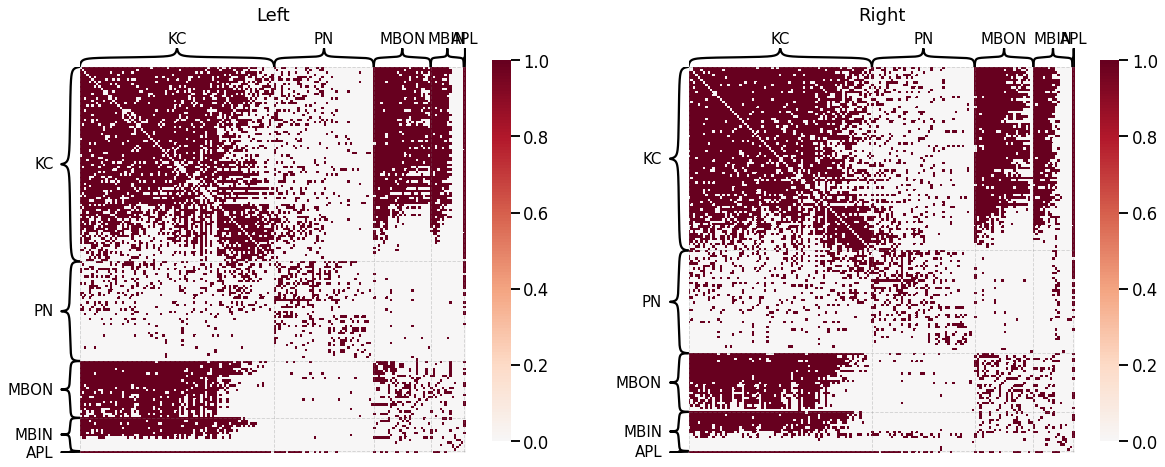

In [4]:
A_l_processed = binarize(symmetrize(A_l))
A_r_processed = binarize(symmetrize(A_r))

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

graspy.plot.heatmap(A_l_processed, inner_hier_labels=nodes_l, transform='binarize', hier_label_fontsize=15, sort_nodes=True, ax=ax[0], title="Left")
graspy.plot.heatmap(A_r_processed, inner_hier_labels=nodes_r, transform='binarize', hier_label_fontsize=15, sort_nodes=True, ax=ax[1], title="Right")

In [5]:
num_dims1 = select_dimension(A_l_processed)[0][-1]
num_dims2 = select_dimension(A_r_processed)[0][-1]
n_components = max(num_dims1, num_dims2)

print(n_components)

ase = AdjacencySpectralEmbed(n_components=2, diag_aug=True, check_lcc=False)
X1_hat = ase.fit_transform(A_l_processed)
X2_hat = ase.fit_transform(A_r_processed)

3


In [74]:
def hypothesis_test(X1, X2):
    tests = [KSample('Dcorr'), KSample('MGC'), KSample('HSic', compute_distance=gaussian)]
    
    pvals = []
    for test in tests:
        res = test.test(X1, X2)
        pvals.append(res[1])
        
    return pvals

def run_non_replacement(X1_hat, X2_hat, n_sims=100):
    N = X1_hat.shape[0]
    M = X2_hat.shape[0]
    X1_cov = _fit_plug_in_variance_estimator(X1_hat)(X1_hat)
    X2_cov = _fit_plug_in_variance_estimator(X2_hat)(X2_hat)
    
    def worker():
        X1_new = np.array(
            [multivariate_normal(X1_hat[idx], X1_cov[idx]) for idx in range(N)]
        )
        X2_new = np.array(
            [multivariate_normal(X2_hat[idx], X2_cov[idx]) for idx in range(M)]
        )
        pvals = hypothesis_tests(X1_new, X2_new)
        
        return pvals
    
    res = Parallel(-1)(delayed(worker)() for _ in range(n_sims))
    
    return res